In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import xgboost
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [3]:
df=pd.read_csv('./fdf-embedd.csv')
df = df.drop(df.columns[0], axis=1)
df=df.fillna(-1)
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')

df["date"]=df.date.astype(str)
df["Year"]=df.date.str[:4]
df["Month"]=df.date.str[5:7]
df["Day"]=df.date.str[8:]


df["Year"]=df.Year.astype(int)
df["Month"]=df.Month.astype(int)
df["Day"]=df.Day.astype(int)

In [4]:
# df.head()

In [5]:
train=df[df["nDate"]<='2019-09-15']


gb=train.groupby('clicks_level')
# newdf=pd.concat([y.sample(50000,replace=True) for y in gb.get_group(1)])
train=pd.concat([train,gb.get_group(1).sample(800000,replace=True),gb.get_group(2).sample(800000,replace=True)])
train=train.sort_values(['date'])

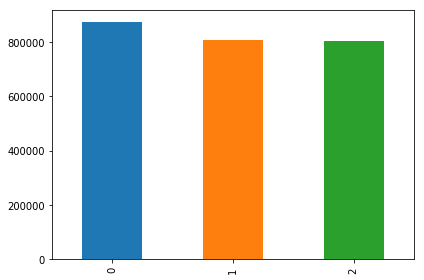

In [6]:
pd.value_counts(train['clicks_level']).plot.bar()
plt.tight_layout()

In [7]:
test=df[df["nDate"]>'2019-09-15']


gb=test.groupby('clicks_level')
# newdf=pd.concat([y.sample(50000,replace=True) for y in gb.get_group(1)])
test=pd.concat([test,gb.get_group(1).sample(80000,replace=True),gb.get_group(2).sample(80000,replace=True)])
test=test.sort_values(['date'])

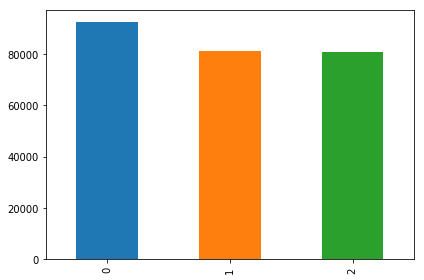

In [8]:
pd.value_counts(test['clicks_level']).plot.bar()
plt.tight_layout()

In [9]:
train_y=train["clicks_level"]
train_X=train.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)


test_y=test["clicks_level"]
test_X=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

In [6]:
df["date"]=df.date.astype(str)
df["Year"]=df.date.str[:4]
df["Month"]=df.date.str[5:7]
df["Day"]=df.date.str[8:]


df["Year"]=df.Year.astype(int)
df["Month"]=df.Month.astype(int)
df["Day"]=df.Day.astype(int)


labels=df["clicks_level"]
df=df.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)


# Scaling Values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [7]:
values = scaled
# values=df.values
y=labels
# n_train_hours = 872663
# n_train_hours= 2197001
n_train_hours=2401206
train_X ,train_y= values[:n_train_hours, :],y[:n_train_hours]
test_X,test_y = values[n_train_hours:, :],y[n_train_hours:]


In [13]:
train_X.shape,train_y.shape

((2480874, 63), (2480874,))

In [14]:
test_X.shape,test_y.shape

((253828, 63), (253828,))

In [21]:
def build_model(lr=0.1,depth=8,estimators=10):
    clf=xgboost.XGBClassifier(learning_rate = lr,max_depth = depth,early_stopping_rounds=10,n_estimators = estimators,min_child_weight= 1, scale_pos_weight= 1,objective='reg:linear',colsample_bytree=0.8,subsample=0.6)
    return clf

In [22]:
eset = [(train_X, train_y), (test_X, test_y)]
clf=build_model(lr=0.08,depth=8,estimators=20)
clf.fit(train_X,train_y,eval_set=eset,verbose=True)

[0]	validation_0-merror:0.203903	validation_1-merror:0.303521
[1]	validation_0-merror:0.188186	validation_1-merror:0.279221
[2]	validation_0-merror:0.184673	validation_1-merror:0.270478
[3]	validation_0-merror:0.184235	validation_1-merror:0.262189
[4]	validation_0-merror:0.178458	validation_1-merror:0.258273
[5]	validation_0-merror:0.176652	validation_1-merror:0.256926
[6]	validation_0-merror:0.175643	validation_1-merror:0.263092
[7]	validation_0-merror:0.174833	validation_1-merror:0.259124
[8]	validation_0-merror:0.17318	validation_1-merror:0.257935
[9]	validation_0-merror:0.17082	validation_1-merror:0.260145
[10]	validation_0-merror:0.16899	validation_1-merror:0.264837
[11]	validation_0-merror:0.167573	validation_1-merror:0.268213
[12]	validation_0-merror:0.166278	validation_1-merror:0.266657
[13]	validation_0-merror:0.16438	validation_1-merror:0.263572
[14]	validation_0-merror:0.163654	validation_1-merror:0.263415
[15]	validation_0-merror:0.162341	validation_1-merror:0.262398
[16]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, early_stopping_rounds=10, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

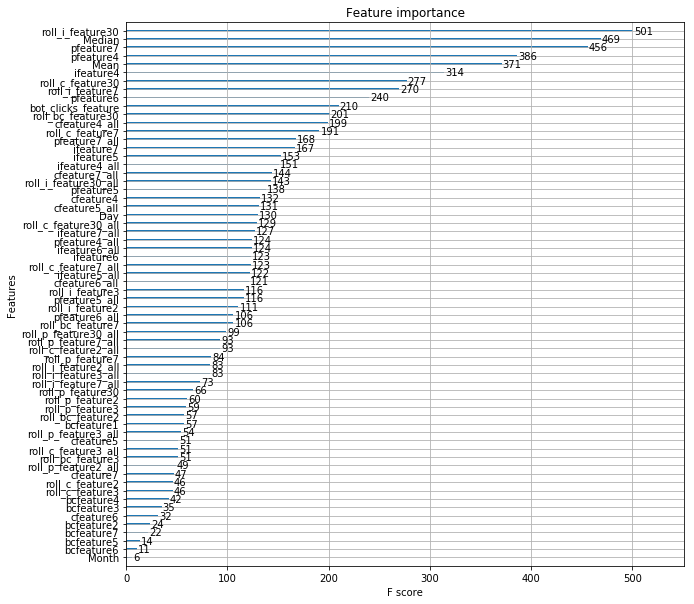

In [23]:
fig,ax=plt.subplots(figsize=(10,10))
xgboost.plot_importance(clf,ax=ax)

In [24]:
ypred=clf.predict(test_X)
print (sklearn.metrics.f1_score(test_y,ypred,average='macro'))
print (sklearn.metrics.accuracy_score(test_y,ypred))

0.7277194807716673
0.7322950974675765


In [25]:
df=pd.read_csv('./fdf-embedd.csv')
df = df.drop(df.columns[0], axis=1)
df=df.fillna(-1)
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')


# df[df["nDate"]<='2019-09-15']

# # TimeSeries Split
# train=df[df["nDate"]<'2019-09-15']
# Y_train=train["clicks_level"].values
# X_train=train.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1).values

# test=df[df["nDate"]>='2019-09-15']
# Y_test=test["clicks_level"].values
# X_test=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1).values


In [26]:
df[df["nDate"]>'2019-09-15']



df["date"]=df.date.astype(str)
df["Year"]=df.date.str[:4]
df["Month"]=df.date.str[5:7]
df["Day"]=df.date.str[8:]


df["Year"]=df.Year.astype(int)
df["Month"]=df.Month.astype(int)
df["Day"]=df.Day.astype(int)


labels=df["clicks_level"]
df=df.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

# scaled = scaler.transform(df.values)

In [27]:
ypred=clf.predict(df)
print (sklearn.metrics.f1_score(labels,ypred,average='macro'))
print (sklearn.metrics.accuracy_score(labels,ypred))

0.4933119823916394
0.9255362151714063


In [17]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".1%")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
#     for t in heatmap.texts: t.set_text(t.get_text() + " %")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

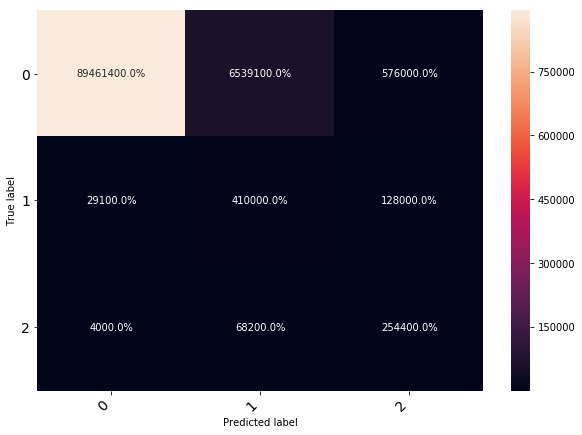

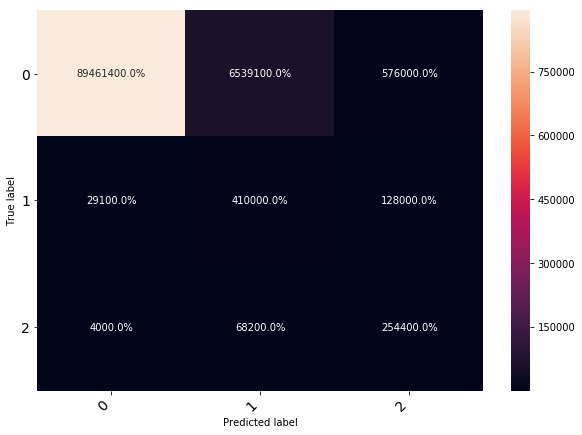

In [21]:
print_confusion_matrix(sklearn.metrics.confusion_matrix(labels,ypred),class_names=['0','1','2'])

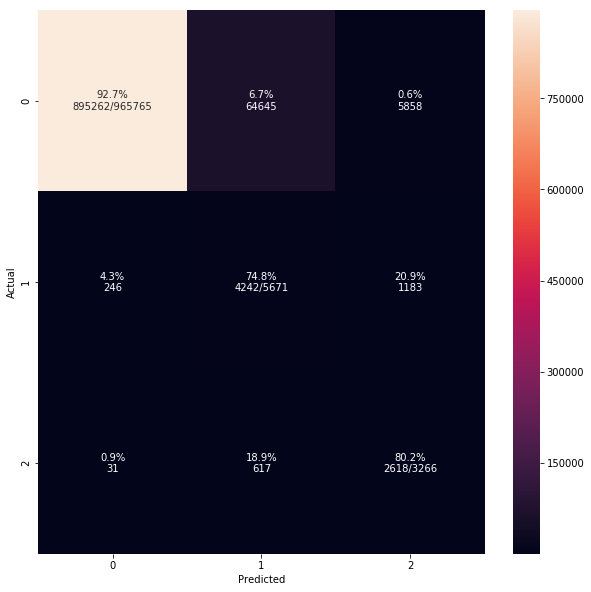

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
#     plt.savefig(filename)


cm_analysis(labels,ypred,filename="Null",labels=[0,1,2])

In [23]:
labels

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
974672    0
974673    0
974674    0
974675    0
974676    0
974677    0
974678    0
974679    0
974680    0
974681    0
974682    0
974683    0
974684    0
974685    0
974686    0
974687    0
974688    0
974689    0
974690    0
974691    0
974692    0
974693    0
974694    0
974695    0
974696    0
974697    0
974698    0
974699    0
974700    0
974701    0
Name: clicks_level, Length: 974702, dtype: int64